In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#export
from exp.nb_09c import *

# PIL transforms

In [3]:
#export
make_rgb._order = 0

In [4]:
path = untar_data(imagenette_160); path

PosixPath('/home/ubuntu/learnai/dl/data/imagenette-160')

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [6]:
def get_il(tfms):
    return ImageList.from_files(path, tfms=tfms)

In [7]:
il = get_il(tfms)

In [8]:
ii = 6100

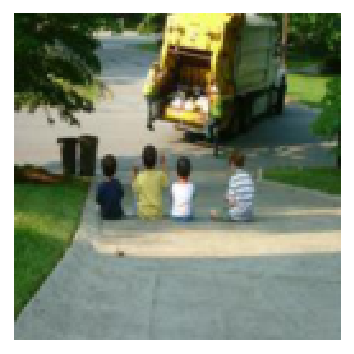

In [9]:
show_image(il[ii])

In [10]:
img = PIL.Image.open(il.items[ii])

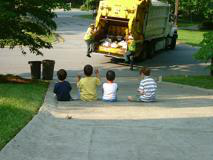

In [11]:
img

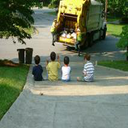

In [12]:
img.resize((128, 128), resample=PIL.Image.ANTIALIAS)

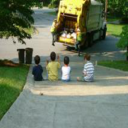

In [13]:
img.resize((128, 128), resample=PIL.Image.BILINEAR)

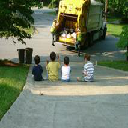

In [14]:
img.resize((128, 128), resample=PIL.Image.NEAREST)

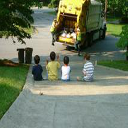

In [15]:
img.resize((256, 256), resample=PIL.Image.BICUBIC).resize((128, 128), resample=PIL.Image.NEAREST)

## Flip

In [16]:
#export
import random

In [17]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [45]:
il1 = get_il(tfms)
il1.items = [il1.items[ii]]*64
dl = DataLoader(il1, 8)

In [46]:
x = next(iter(dl))

In [20]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))
    
def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None:
        r = int(math.ceil(n/c))
    if figsize is None:
        figsize=(c*3, r*3)
    fig, axes = plt.subplots(r,c, figsize=figsize)
    for xi, ax in zip(x, axes.flat):
        show_image(xi, ax)

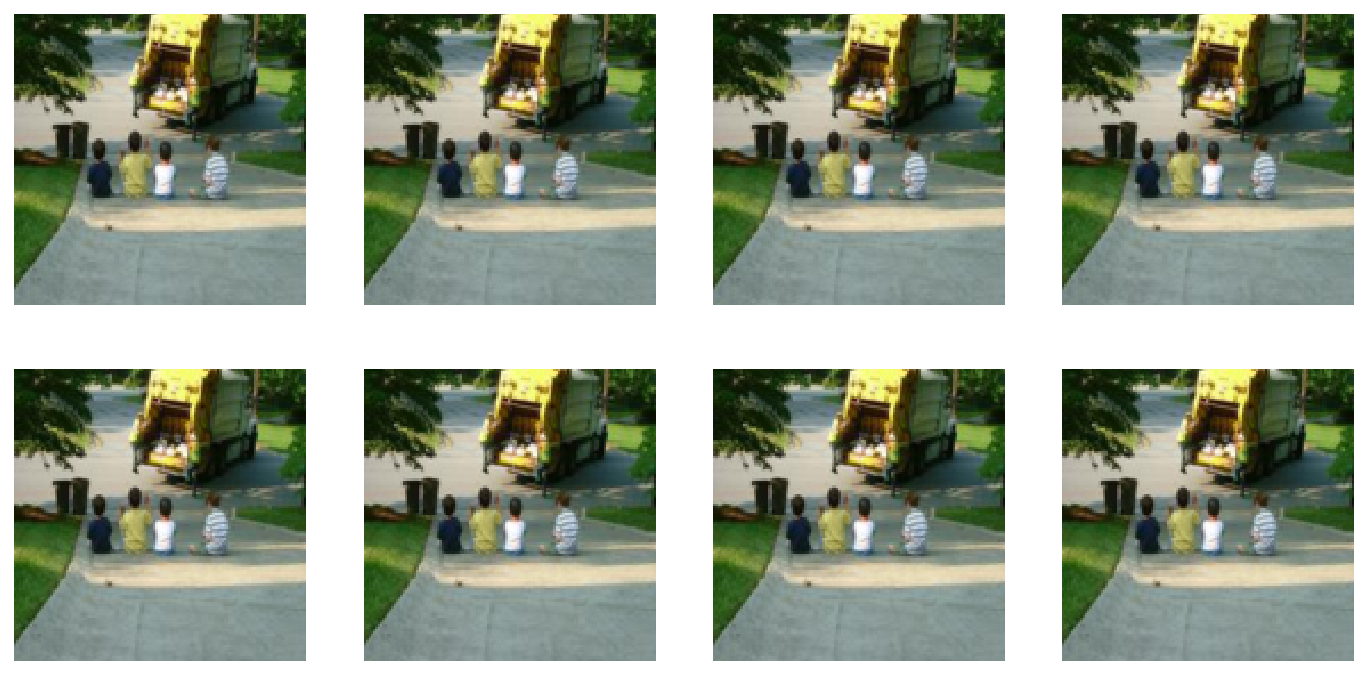

In [21]:
show_batch(x)

In [22]:
il1.tfms.append(pil_random_flip)

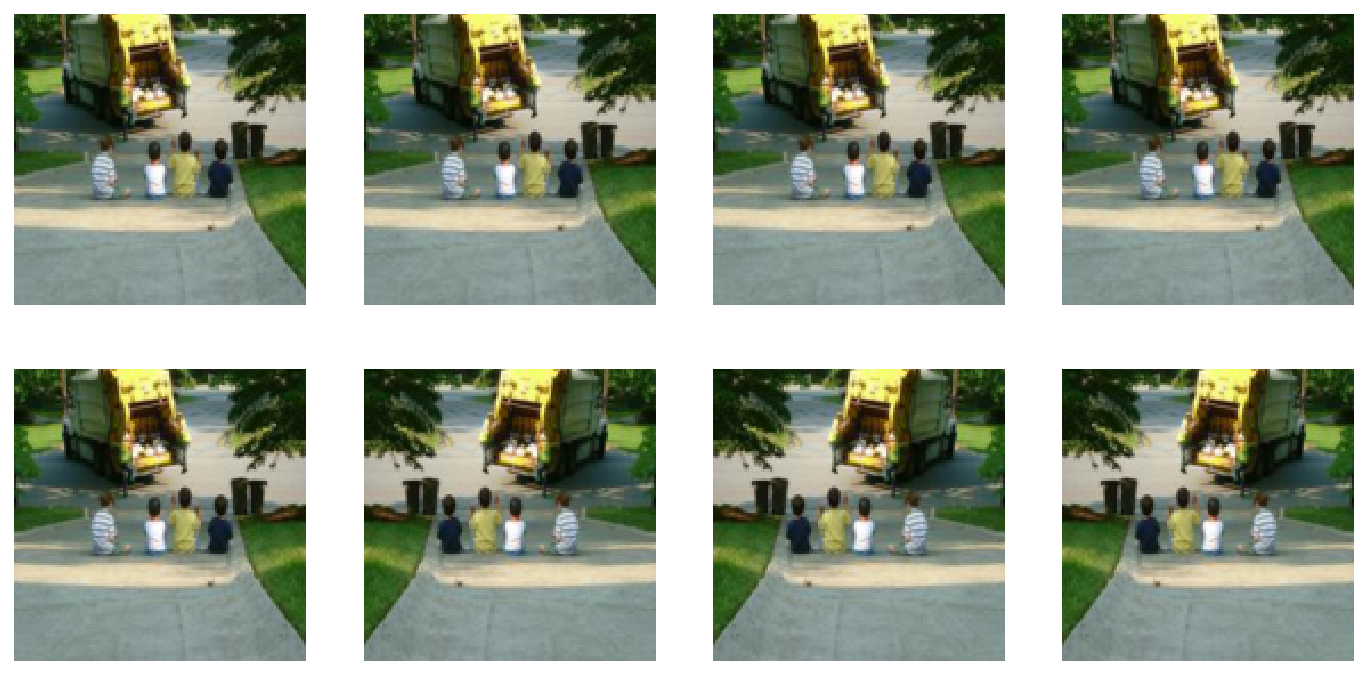

In [23]:
x = next(iter(dl))
show_batch(x)

In [24]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [25]:
#export
class PilTransform(Transform):
    _order=11
    
class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [26]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

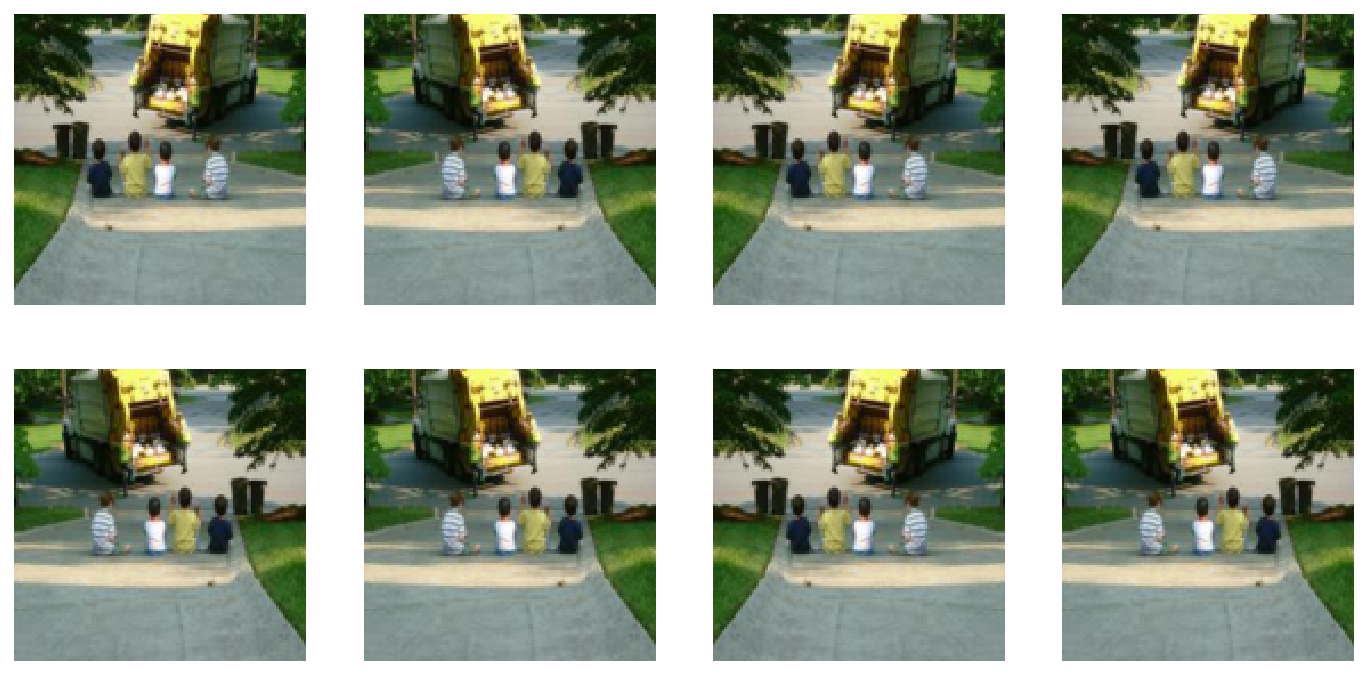

In [27]:
x = next(iter(dl))
show_batch(x)

In [28]:
PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.ROTATE_270, PIL.Image.TRANSVERSE

(0, 4, 6)

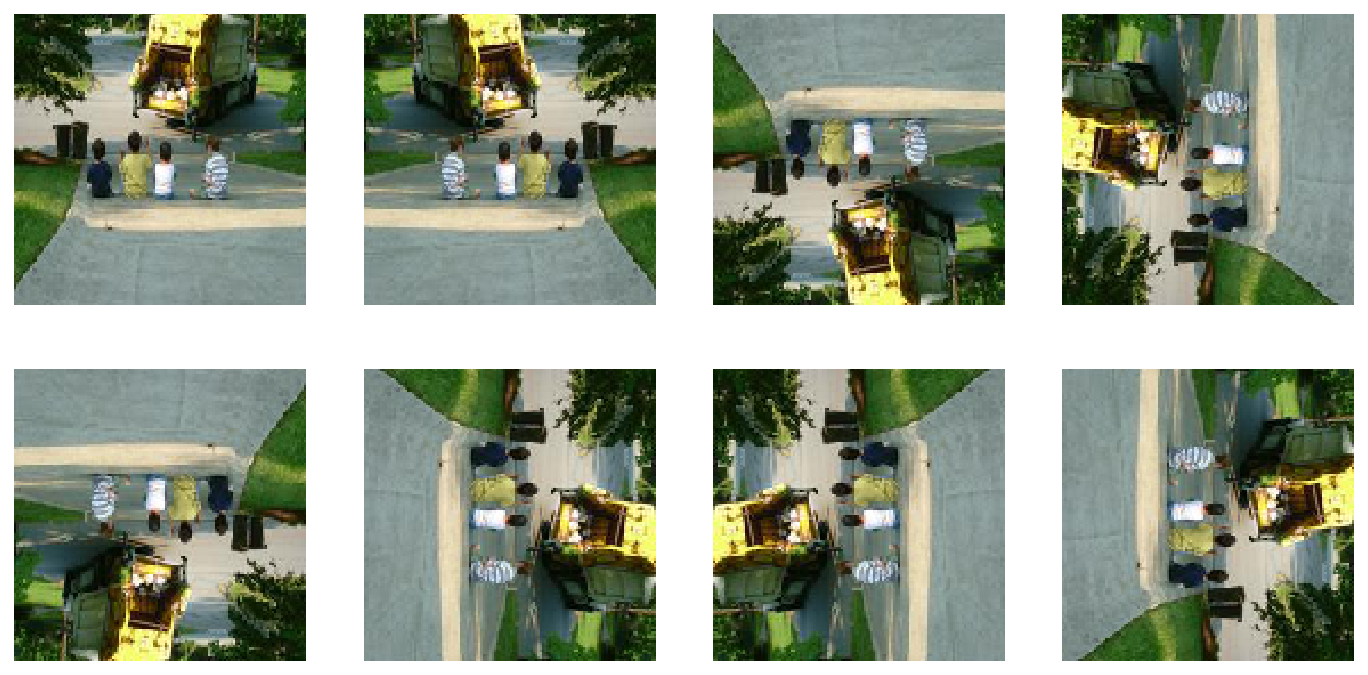

In [29]:
img = PIL.Image.open(il.items[ii])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    if i==0:
        ax.imshow(img)
    else:
        ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [30]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75):
        self.p = p*(7/8)
        
    def __call__(self, x):
        if random.random()>self.p:
            return x
        return x.transpose(random.randint(0, 6))

In [31]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

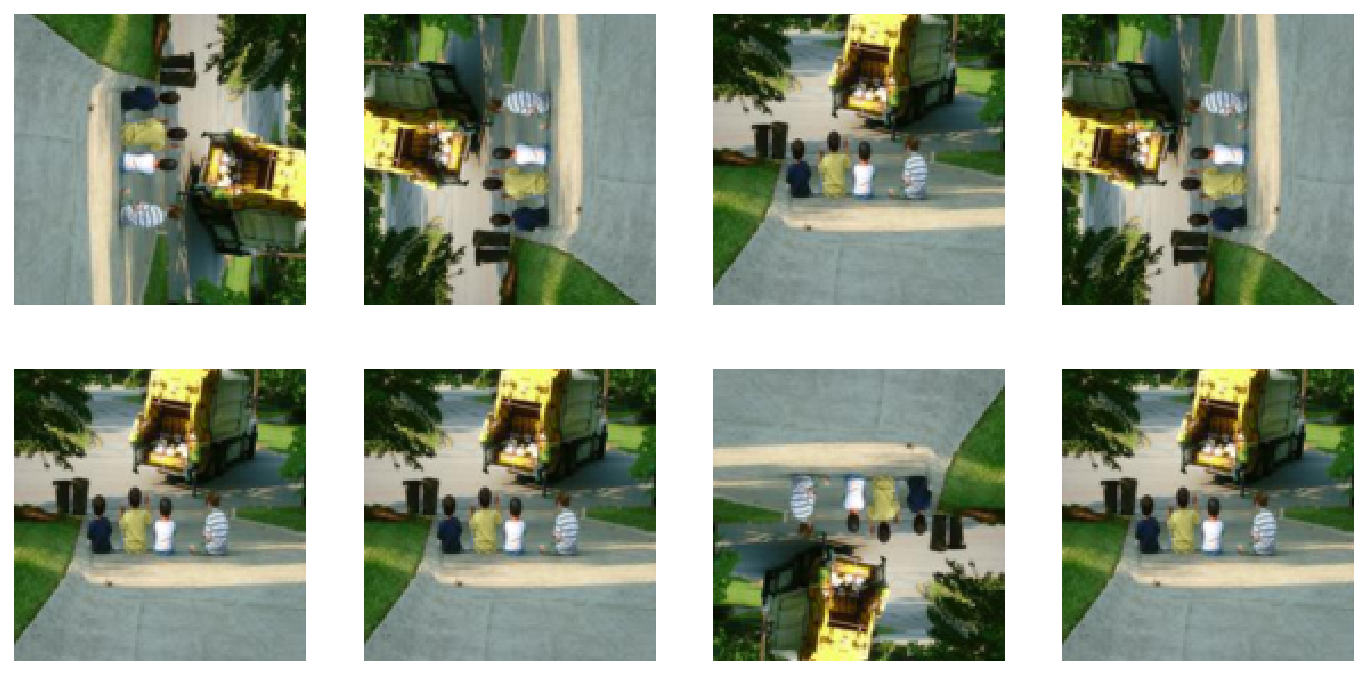

In [32]:
show_batch(next(iter(dl)))

### Random crop

In [33]:
img = PIL.Image.open(il.items[ii])
img.size

(213, 160)

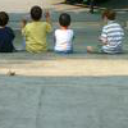

In [34]:
img.crop((60,60,160,160)).resize((128,128), resample=PIL.Image.BILINEAR)

In [35]:
cnr2 = (60,60,160,160)
resample = PIL.Image.BILINEAR

In [36]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

259 µs ± 6.67 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


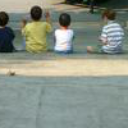

In [37]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [38]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

582 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0], sz[0]])

def default_crop_size(w,h):
    return [w,w] if w<h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample, self.size = resample, process_sz(size)
        if crop_size is None:
            self.crop_size = None
        else:
            self.crop_size = process_sz(crop_size)
        
    def default_crop_size(self, w, h):
        return default_crop_size(w, h)
    
    def __call__(self, x):
        if self.crop_size is None:
            csize = self.default_crop_size(*x.size)
        else:
            csize = self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
            
    def get_corners(self, w, h):
        return (0, 0, w, h)
    
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w, h):
        return [w/self.scale, h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [56]:
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

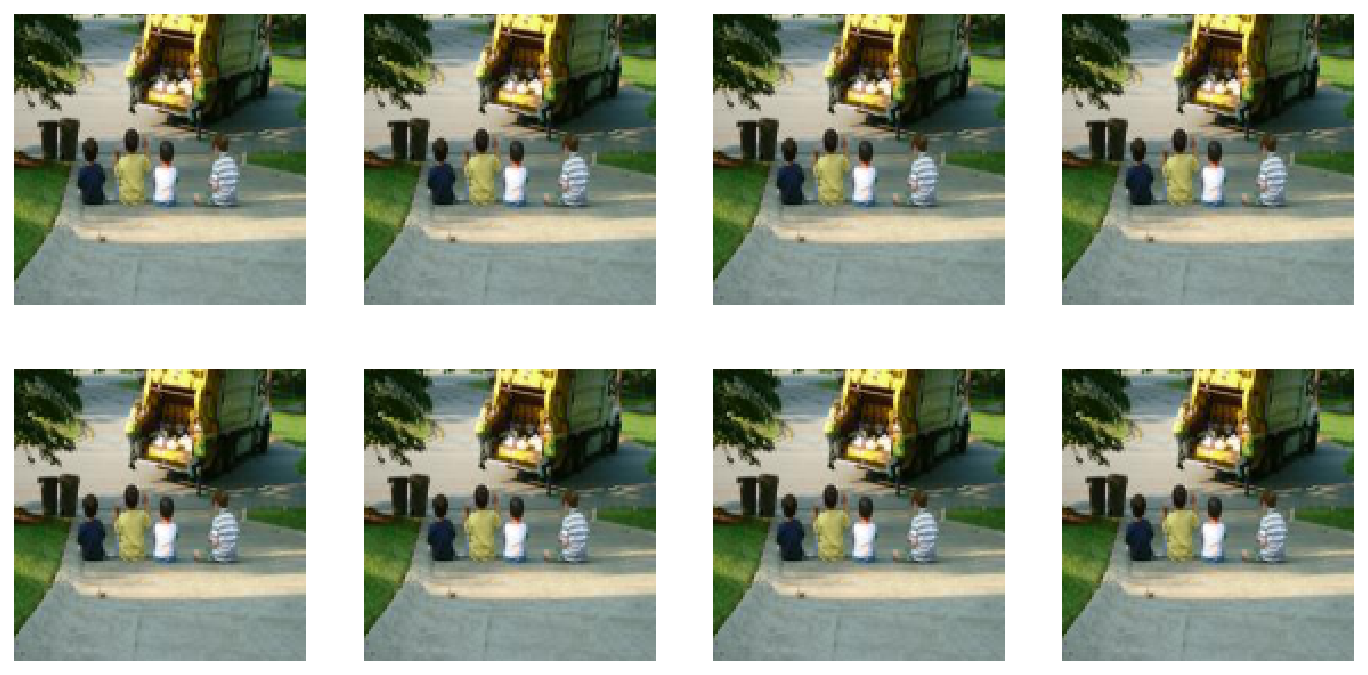

In [57]:
show_batch(next(iter(dl)))

## RandomResizeCrop

In [82]:
#export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale, self.ratio = scale, ratio
        
    def get_corners(self, w, h, wc, hc):
        area = w*h
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
            
        # Fallback to central crop
        if w/h<self.ratio[0]:
            size = (w, int(w/self.ratio[0]))
        elif w/h>self.ratio[1]:
            size = (int(h*self.ratio[1]), h)
        else:
            size = (w,h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)
#         left, top = randint(0, w-self.crop_size[0]), randint(0, h-self.crop_size[1])
#         return (left, top, left+self.crop_size[0], top+self.crop_size[1])

In [62]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

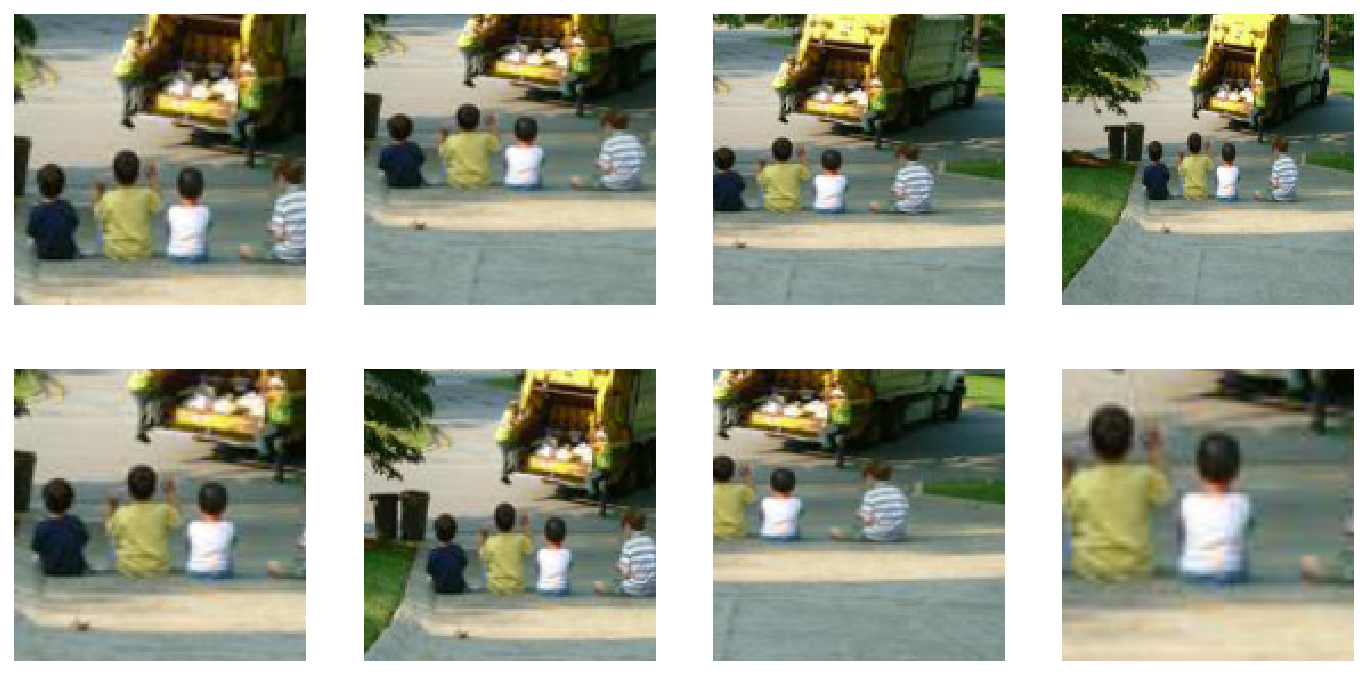

In [63]:
show_batch(next(iter(dl)))

In [64]:
#export
from torch import FloatTensor, LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8,1)
    return list(torch.solve(B,A)[0][:,0])

In [65]:
#export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w, h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords, targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [66]:
targ = ((0,0),(0,128),(128,128),(128,0))
src = ((90,60),(30,280),(310,280),(250,60))

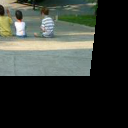

In [67]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [68]:
%timeit -n 10 warp(img, (128,128), src)

535 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

304 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


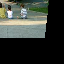

In [70]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

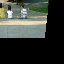

In [71]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [72]:
#export
def uniform(a,b):
    return a + (b-a)*random.random()

In [73]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST):
        self.resample, self.size, self.magnitude = resample, process_sz(size), magnitude
        if crop_size is None:
            self.crop_size = None
        else:
            self.crop_size = process_sz(crop_size)
            
    def __call__(self, x):
        if self.crop_size is None:
            csize = default_crop_size(*x.size)
        else:
            csize = self.crop_size
        up_t, lr_t = uniform(-self.magnitude, self.magnitude), uniform(-self.magnitude, self.magnitude)
        left, top = randint(0, x.size[0]-csize[0]), randint(0, x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left, top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [74]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

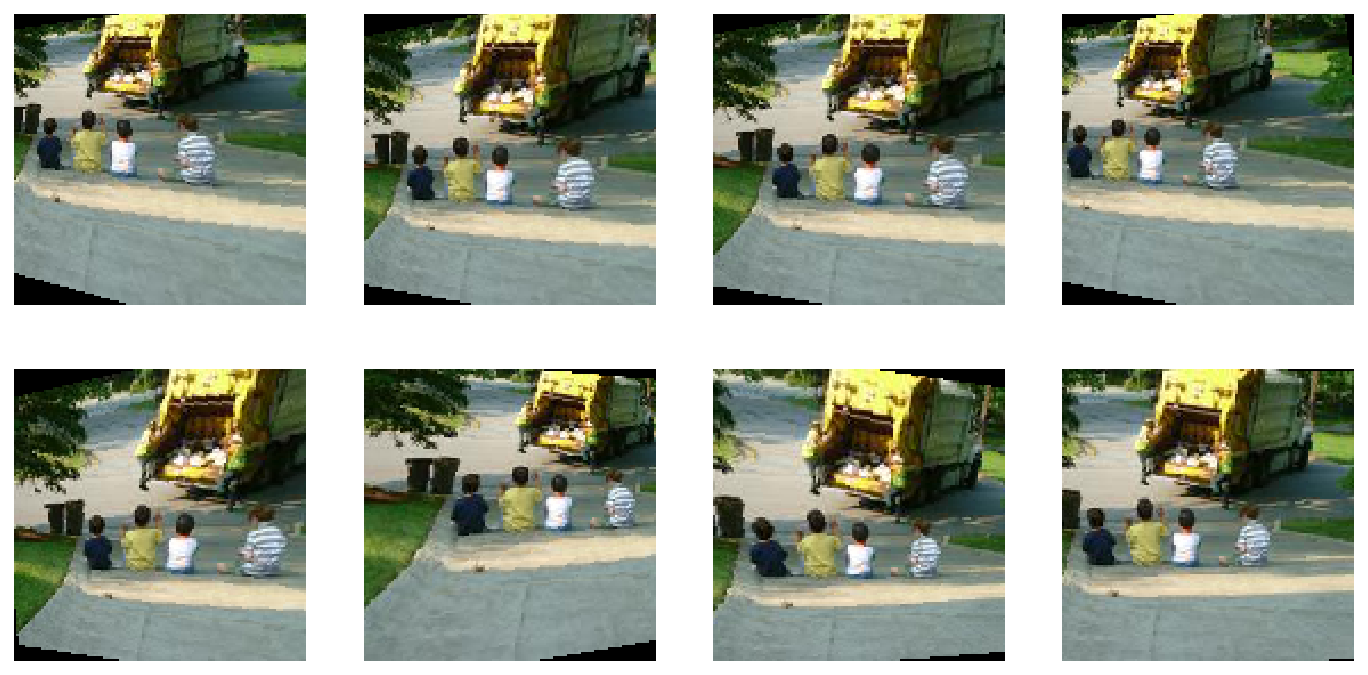

In [75]:
x = next(iter(dl))
show_batch(x)

In [76]:
#export
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR):
        self.resample, self.size, self.magnitude = resample, process_sz(size), magnitude
        if crop_size is None:
            self.crop_size = None
        else:
            self.crop_size = process_sz(crop_size)
            
    def __call__(self, x):
        if self.crop_size is None:
            csize = default_crop_size(*x.size)
        else:
            csize = self.crop_size
        left, top = randint(0, x.size[0]-csize[0]), randint(0, x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn = min(self.magnitude, top/csize[1], (x.size[1]-top)/csize[1]-1)
        up_t, lr_t = uniform(-top_magn, top_magn), uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left, top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [79]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 120, magnitude=0.2), to_byte_tensor, to_float_tensor]

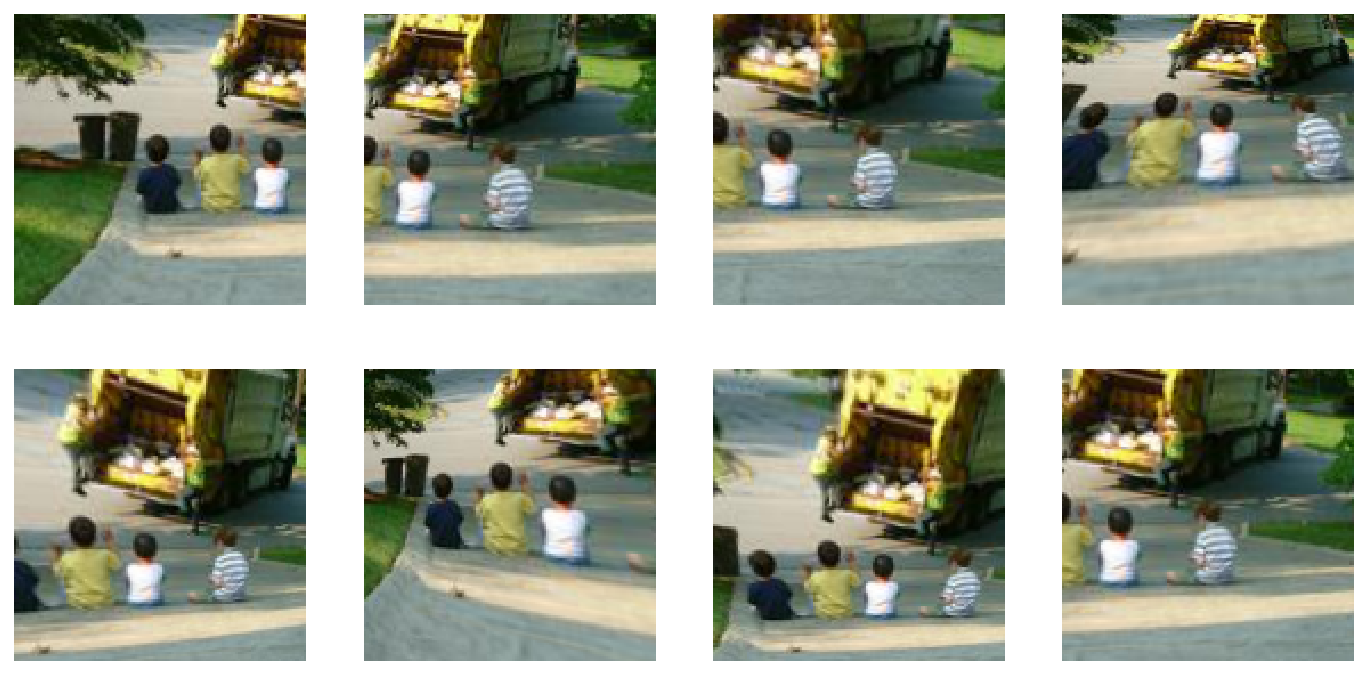

In [80]:
x = next(iter(dl))
show_batch(x)

## Faster tensor creation

In [81]:
[(o._order, o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f2050fe1850>),
 (11, <__main__.PilRandomDihedral at 0x7f20467f58d0>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [83]:
#export
import numpy as np

def np_to_float(x):
    return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [84]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

173 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
%timeit -n 10 np_to_float(img)

290 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Batch data augmentation

In [87]:
!python notebook2script.py 10_augmentation.ipynb

converted 10_augmentation.ipynb to nb_10.py
